In [39]:
import os
import glob
import pandas as pd

df = pd.read_csv('preprocess/pre_input_6.csv')

train_df = df.dropna(subset=['text', 'Y'])
valid_df = df[df['text'].isna()]

train_df

,회사명,회계년도,분기,profit,text,Y
1,DB손해보험(주),2018,1,210697471,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를현 수준(1.50%)...,1.0
2,DB손해보험(주),2019,1,232419677,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를현재의 1.50%에서...,1.0
3,DB손해보험(주),2020,1,226549867,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를현 수준(1.25%)...,0.0
4,DB손해보험(주),2021,1,221215499,(붙임)통화정책방향 금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를...,0.0
5,DB손해보험(주),2017,2,192880168,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를 현수준(1.25%)...,0.0
...,...,...,...,...,...,...
195,흥국화재해상보험(주),2017,4,71589000,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를 현수준(1.25%)...,0.0
196,흥국화재해상보험(주),2018,4,73599000,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를현 수준(1.50%)...,1.0
197,흥국화재해상보험(주),2019,4,73006000,금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를현재의 1.50%에서...,0.0
198,흥국화재해상보험(주),2020,4,69680000,(붙임)통화정책방향 금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를...,0.0


의결문 최대 길이: 3712
의결문 평균 길이: 2478.8947368421054


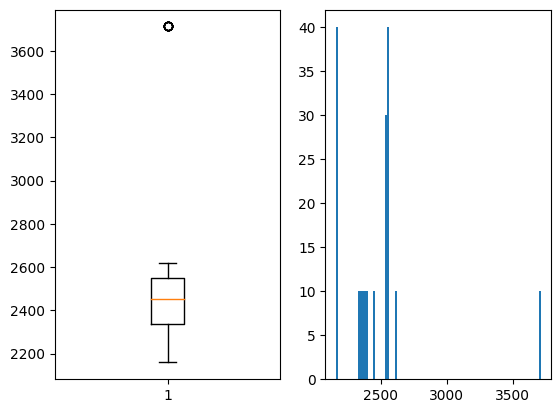

In [40]:
import numpy as np

text_length = [len(_text)for _text in train_df['text'].values]
print(f'의결문 최대 길이: {np.max(text_length)}')
print(f'의결문 평균 길이: {np.mean(text_length)}')

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.boxplot(text_length)
plt.subplot(1,2,2)
plt.hist(text_length,bins=100)
plt.show()

In [41]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Okt()

tokenized_sentences = []

for _, row in train_df.iterrows():
    sentence = row['text']
    tokens = tokenizer.pos(sentence)
    tokenized_sentence = ' '.join([word+'/'+pos for word, pos in tokens])
    tokenized_sentences.append(tokenized_sentence)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tokenized_sentences)

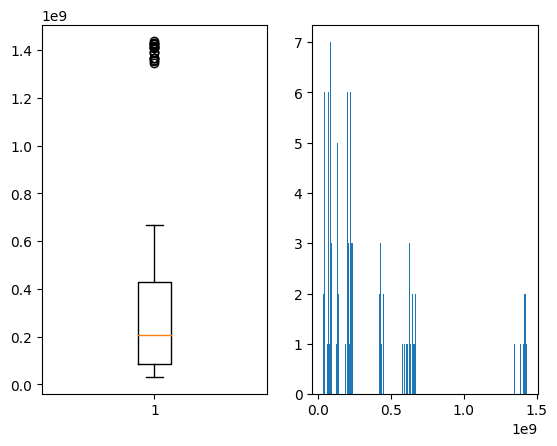

In [43]:
lst_profit = [profit for profit in train_df['profit'].values]
lst_label = [label for label in train_df['Y'].values]

plt.subplot(1,2,1)
plt.boxplot(lst_profit)
plt.subplot(1,2,2)
plt.hist(lst_profit, bins=500)
plt.show()

In [44]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

X = tfidf_matrix.toarray()
y = train_df['Y']

vocab_size = 10000
max_len = 2550

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1892)
X_train = pad_sequences(X_train, maxlen=max_len)

In [49]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('ckcp/GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=8, validation_split=0.2)

Epoch 1/15


2023-06-20 01:08:03.921350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 01:08:03.924462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 01:08:03.926961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - ETA: 0s - loss: 0.6993 - acc: 0.4959

2023-06-20 01:08:31.460927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 01:08:31.463121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 01:08:31.464696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_acc improved from -inf to 0.48387, saving model to ckcp/GRU_model.h5
16/16 [==============================] - 29s 2s/step - loss: 0.6993 - acc: 0.4959 - val_loss: 0.7052 - val_acc: 0.4839
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 0.6963 - acc: 0.5289
Epoch 2: val_acc did not improve from 0.48387
16/16 [==============================] - 26s 2s/step - loss: 0.6963 - acc: 0.5289 - val_loss: 0.7036 - val_acc: 0.4839
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.6939 - acc: 0.5289
Epoch 3: val_acc did not improve from 0.48387
16/16 [==============================] - 28s 2s/step - loss: 0.6939 - acc: 0.5289 - val_loss: 0.7037 - val_acc: 0.4839
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.6971 - acc: 0.5289
Epoch 4: val_acc did not improve from 0.48387
16/16 [==============================] - 27s 2s/step - loss: 0.6971 - acc: 0.5289 - val_loss: 0.6953 - val_acc: 0.4839
Epoch 5/15
16/16 [==================